In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from utils_datamodel.utils import FastFillTensorDataLoader

from src.semi_sub_utils import get_ds_test_from_df, get_ds_from_df, expCollector, log_pointwise_predictive_likelihood
from src.ess import SemiSubEllipticalSliceSampling
from src.semi_subspace import *
from src.base_models import RegNet, NllLoss
from src.semiSub_model import getModel
from src.pyro_models import pyroSemiSubspace, pyroSemiSubspaceBlackbox
from src.plot import plot_predictive_regression, plot_curve_solutions_regression, plot_subspace_solution_regression, plot_data, plot_subspace, plot_subspace_solution_regression_pyro

import pyro
from pyro.infer.autoguide import init_to_sample
from pyro.poutine.indep_messenger import IndepMessenger
from copy import deepcopy
import arviz as az
from src.semi_sub_utils import features

# %load_ext tensorboard
sns.set_style("darkgrid")
if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)
%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./semi_subspace_vs_blackBox.ipynb

def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize":figsize
}
plt.rcParams.update(tex_fonts)


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./semi_subspace_vs_blackBox.ipynb
Figure size= [3.2489276324892766, 2.0079477038671003]


### Load data

f_mean = [-0.18565409  6.460015  ]
f_std = [2.5348663 4.450509 ]


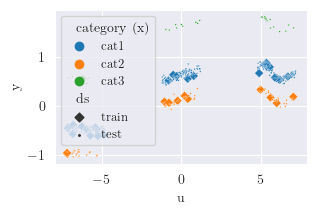

In [3]:
# kwargs = {"dimensions": [200, 50, 50, 50],
use_ortho = False
base_net_kwargs = {"dimensions": [16, 16],
                   "output_dim": 1,
                   "input_dim": 2}
outcome_dist = pyro.distributions.Normal  # outcome distributions
loss_fn = NllLoss(outcome_dist,
                  constrains={'loc': torch.nn.Identity()},
                  scale=.05,
                  reduction='mean')
net_kwargs = dict(lr=0.0025,
                  weight_decay=1e-3,
                  loss_fn=loss_fn,
                  num_structure=2,
                  ortho_layer_name_nn_head="lin[4]" if use_ortho else None
                  )
exp_col = expCollector(wandb_project='Semi_Toy_comp_BlackBox_v2',
                       use_ortho=use_ortho,
                       seed=10,
                       base_net_kwargs=base_net_kwargs,
                       net_kwargs=net_kwargs,
                       nll_fn=loss_fn)

df, df_test = prepare_data(exp_col, reload=False)
plt.figure()
plot_data(exp_col)

dataset, (f_mean, f_std) = get_ds_from_df(df, device)
exp_col.f_mean = f_mean  # store data mean and data std
exp_col.f_std = f_std
dataset_test = get_ds_test_from_df(df_test, device, f_mean, f_std)
cuda_loader = FastFillTensorDataLoader(dataset, batch_size=len(df), shuffle=True,
                                       pin_memory=False)
exp_col.train_dataloader = cuda_loader
cuda_loader_test = FastFillTensorDataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False,
                                            pin_memory=False)
exp_col.test_dataloader = cuda_loader_test

## Train our subspace approach
1. train the curve model to generate a projection matrix
2. run HMC on the subspace

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./semi_regression.ipynb.


SemiAdditive
RegNet


wandb: Currently logged in as: ddold. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `valida

SemiAdditive


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3000` reached.
wandb: Adding directory to artifact (./wandb/run-20230831_094552-n7dxa17m/files/checkpoints)... Done. 0.0s
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(


SemiAdditiveSubspace
SemiAdditive
Subspace
RegNet


100%|██████████| 1600/1600 [00:01<00:00, 888.36it/s]
/home/daniel/remote/semi_subspace/src/plot.py:301: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/torch/csrc/utils/tensor_new.cpp:245.)
  all_curve_params = torch.as_tensor(all_curve_params)


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss_epoch,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,2999
train/loss_epoch,-1.56725
train/loss_step,-1.56725
trainer/global_step,2999


***************************
* Initialisation finished *
***************************


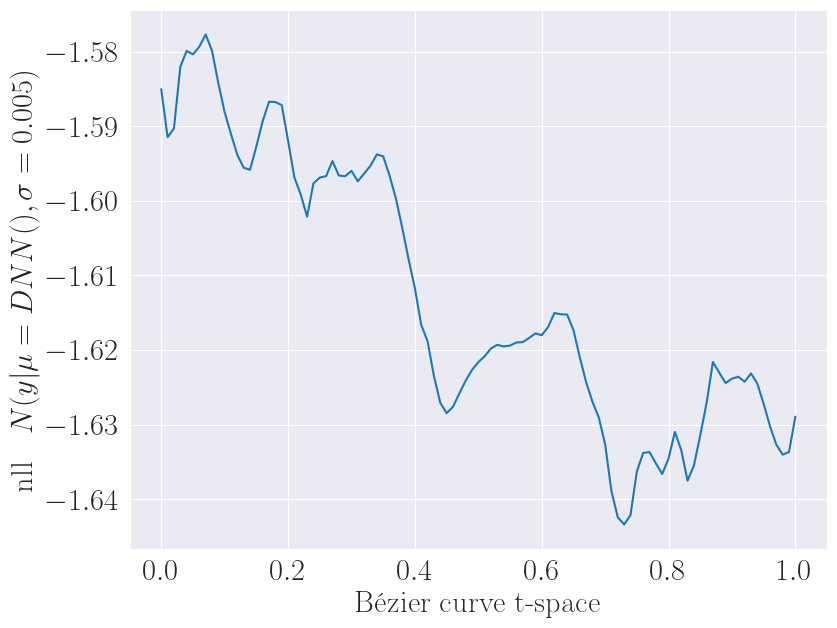

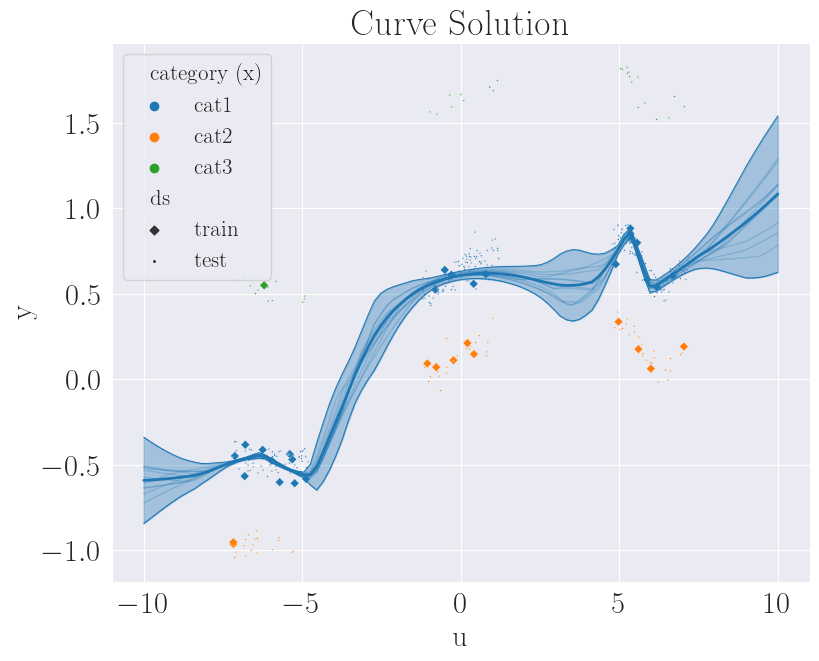

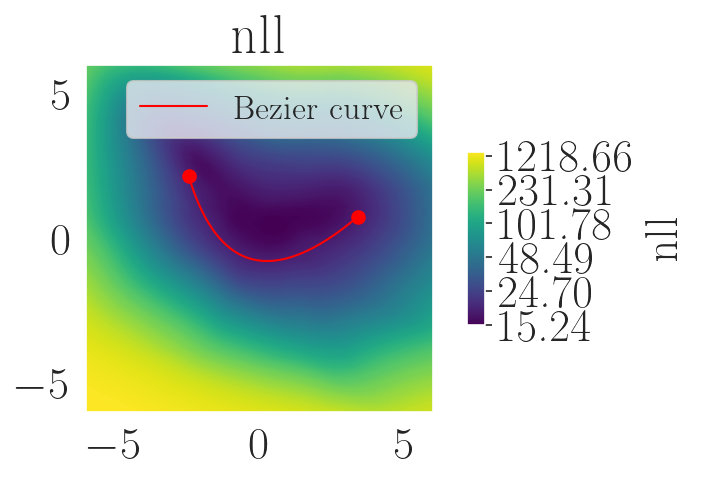

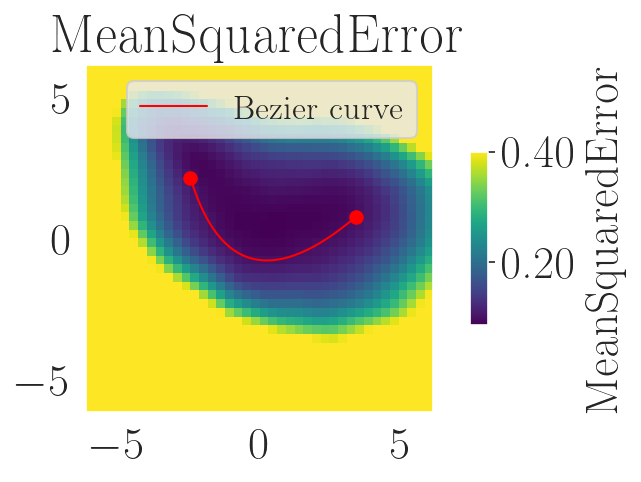

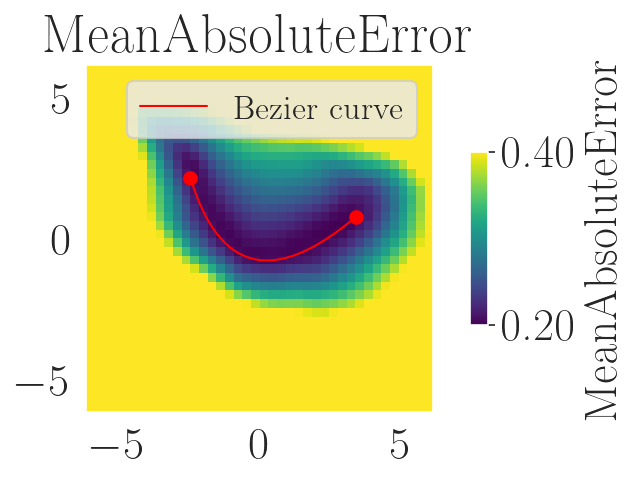

In [3]:
best_curve_model, wandb_exp_id, _, wandb_logger = initialize_subspace_model_v2(
    exp_col=exp_col,
    plot_predictive_f=plot_predictive_regression,
    plot_curve_solution_f=plot_curve_solutions_regression)
wandb.finish()
print("*" * 27)
print("* Initialisation finished *")
print("*" * 27)

### Run HMC on subspace

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10
wandb:   1 of 1 files downloaded.  


SemiAdditive
RegNet
Name: model_curve, ID: n7dxa17m
This run used following artifacts:
Last Acc None
loaded artifact: 
SemiAdditiveModel
model_state_n7dxa17m:v0


Global seed set to 10


SemiAdditive
Instantiate semi subspace model for ess
SemiAdditiveSubspace
SemiAdditive
Subspace
RegNet
[[4.29149656e+00 3.69139525e+00 4.36081344e-16]]


Warmup [1]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [9]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [10]:   0%|          | 0/800 [00:00, ?it/s]

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_k

test_lppd,417.91327


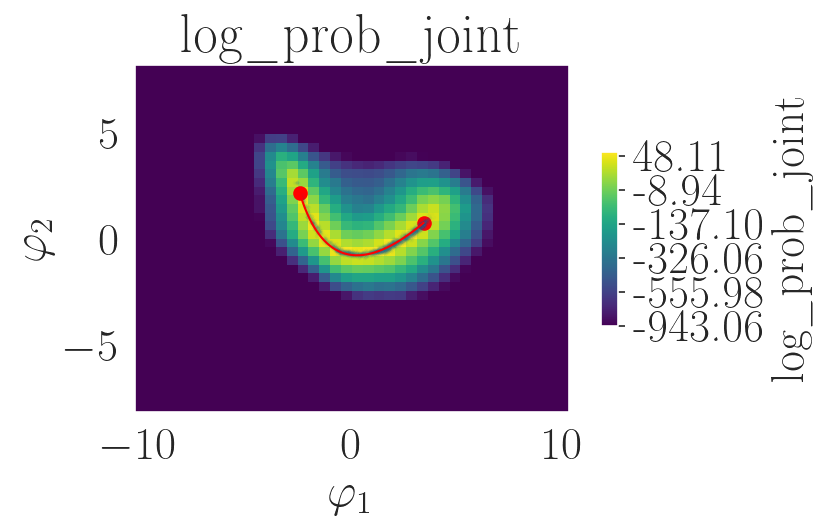

In [4]:
num_chains=10
num_warmup=400
num_samples=400
prior_scale=1.
# create subspace model
subspace_model, wandb_logger = load_subspace_model(exp_col,
                                                   best_curve_model,
                                                   wandb_exp_id)
subspace_model_ = deepcopy(subspace_model)

# %% Run HMC on the subspace
torch.set_default_dtype(torch.float32)
pyro.clear_param_store()

pyro_model = pyroSemiSubspace(
    mean=subspace_model_.mean.to(dtype=torch.float32),
    cov_factor=subspace_model_.cov_factor.to(dtype=torch.float32),
    sequential_dnn=subspace_model_.dnn,
    module_structure=subspace_model_.structure_lin,
    outcome_dist=loss_fn.dist_)

pyro.set_rng_seed(8)
u_train, x_train, y_train = exp_col.train_dataloader.dataset[:]
nuts_kernel = pyro.infer.NUTS(pyro_model,
                                jit_compile=False,
                                adapt_step_size=True,
                                step_size=1e-5,
                                target_accept_prob=0.6,
                                init_strategy=init_to_sample)
mcmc = pyro.infer.MCMC(nuts_kernel,
                       num_samples=num_samples,
                       warmup_steps=num_warmup,
                       num_chains=num_chains,
                       mp_context='spawn')
mcmc.run(u_train, x_train, y_train)
wandb_logger.experiment.config.update({'num_chains': num_chains,
                                        'num_warmup': num_warmup,
                                        'num_samples': num_samples,
                                        'prior_scale': prior_scale,
                                        'seed': exp_col.seed})
# create arviz inference object
az_post_hmc = az.from_pyro(mcmc, log_likelihood=False)
az_post_hmc = az_post_hmc.rename({
    'structure_nn.weight': 'theta',
    'structure_nn.weight_dim_0': 'theta_dim_0',
    'structure_nn.weight_dim_1': 'theta_dim_1'})
# save samples with wandb
az_post_hmc.to_netcdf("az_subspace_posterior.nc")
art = wandb.Artifact(f"data_{wandb_logger.experiment.id}", type="xarray",
                        description="posterior from subspace model")
art.add_file("az_subspace_posterior.nc")
wandb_logger.experiment.log_artifact(art)
# save pyro model state dict
torch.save(pyro_model.state_dict(), "model_state_dict.pt")
art = wandb.Artifact(f"model_state_{wandb_logger.experiment.id}", type="pyroSemiSubspace",
                        description="pyro model state dict")
art.add_file("model_state_dict.pt")
wandb_logger.experiment.log_artifact(art)

# compute lppd
u_test, x_test, y_test = exp_col.test_dataloader.dataset[:]
lppd_test = log_pointwise_predictive_likelihood(pyro_model, mcmc.get_samples(), u=u_test, x=x_test, y=y_test)
lppd_test = (torch.logsumexp(lppd_test, dim=0) - np.log(lppd_test.shape[0])).sum()
wandb_logger.experiment.summary["test_lppd"] = lppd_test

# compute grid
if exp_col.num_bends == 3:
    plot_subspace_solution_regression_pyro(
        az_post_hmc = az_post_hmc,
        pyro_model = pyro_model,
        dataset = exp_col.train_dataloader.dataset,
        curve_model = best_curve_model,
        mean = subspace_model_.mean,
        cov = subspace_model_.cov_factor
    )
    wandb_logger.experiment.log({'Subspace plot': wandb.Image(plt.gcf())})
wandb.finish()

#### load samples and model from wandb

In [4]:
# load samples
exp_col.num_bends = 3
wandb_exp_id = 'n7dxa17m'

art = wandb.Api().artifact('ddold/Semi_Toy_comp_BlackBox_v2/data_a64myofh:v0')
az_post_hmc= az.from_netcdf(art.file())

# load model state
art = wandb.Api().artifact('ddold/Semi_Toy_comp_BlackBox_v2/model_state_a64myofh:v0')
base_model = getModel(RegNet, seed=exp_col.seed, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(device=device)
num_dnn_params = np.sum([p.numel() for p in base_model.dnn.parameters()])
pyro_model = pyroSemiSubspace(
    mean=torch.zeros(num_dnn_params, device=device, dtype=torch.float32),
    cov_factor=torch.zeros((2, num_dnn_params), device=device, dtype=torch.float32),
    sequential_dnn=base_model.dnn,
    module_structure=base_model.structure_lin,
    outcome_dist=exp_col.nll_fn.dist_)
pyro_model.load_state_dict(torch.load(art.file()))

# convert arviz samples back for pyro model
# samples = az_post_hmc.posterior.rename({
#         'theta' :'structure_nn.weight',
#         'theta_dim_0' :'structure_nn.weight_dim_0',
#         'theta_dim_1' :'structure_nn.weight_dim_1'})
# samples_pyro = {}
# for name in samples.data_vars:
#     var_samples = samples[name].to_numpy()
#     shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
#     var_samples = var_samples.reshape(shape)
#     samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
pyro_model

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
RegNet


pyroSemiSubspace(
  (out_dist): OutcomeDistributionLayer(dist=<class 'pyro.distributions.torch.Normal'>; constrains={'loc': Identity()})
  (sequential_dnn): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (structure_nn): PyroLinear(in_features=2, out_features=1, bias=False)
)

In [5]:
az.summary(az_post_hmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"theta[0, 0]",-0.466,0.017,-0.497,-0.434,0.001,0.001,330.0,802.0,1.03
"theta[0, 1]",0.999,0.053,0.898,1.092,0.004,0.003,207.0,935.0,1.04
varphi[0],1.155,1.612,-1.883,3.465,0.213,0.151,68.0,51.0,1.10
varphi[1],-0.105,0.592,-0.835,0.849,0.069,0.049,101.0,59.0,1.08


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

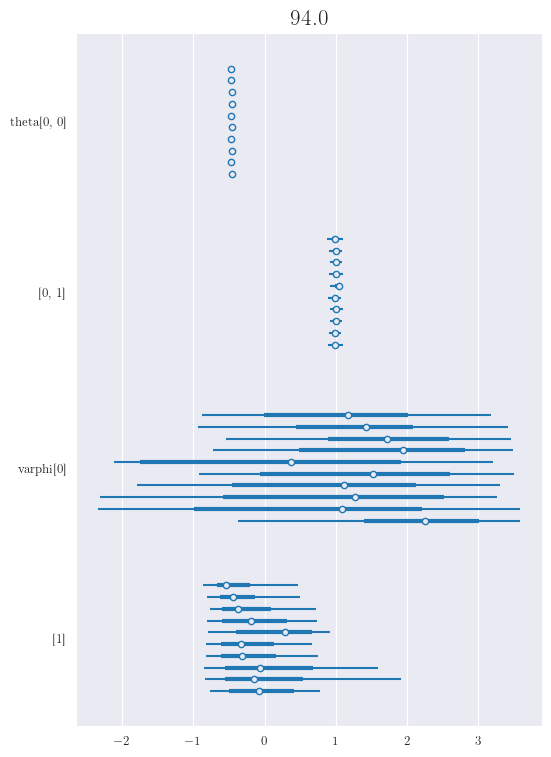

In [6]:
az.plot_forest(az_post_hmc)

## Train BlackBox Subspace Model

#### train BlackBox curve model
In the BlackBox curve model the structural parameter will also be affected by the curve

In [7]:
from src.base_models import RegNet
from src.semiSub_model import getModel
from src.pyro_models import pyroSemiSubspaceBlackbox
from src.curve_models import CurveModel, CurveArchitectureSemiBlackBox


from torchmetrics import MetricCollection
from utils_datamodel.wandb_utils import load_model, parse_runs, wandb_table_to_dataframe
from pytorch_lightning.loggers import WandbLogger
from src.plot import plot_subspace, exclude_project_code_dirs, run_metrics_on_samples
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


# to get class type
wandb_logger = WandbLogger(project=exp_col.wandb_project, log_model=False, name="blackBox_curve", group="RegNetCurve")
# log code
wandb_logger.experiment.log_code("./", name=f"project_code_{wandb_logger.experiment.id}",
                                     exclude_fn=exclude_project_code_dirs)
# to have same sample dimension set num_bends=5
exp_col.num_bends = 5 

base_model = getModel(RegNet, seed=exp_col.seed, **exp_col.base_net_kwargs, **exp_col.net_kwargs)
ckp_dir = os.path.join(wandb_logger.experiment.dir, "checkpoints")
callbacks = [ModelCheckpoint(dirpath=ckp_dir, save_top_k=1, monitor="train/loss")]
trainer = pl.Trainer(devices=1,
                     max_epochs=3000,
                     # max_epochs=30,
                     logger=wandb_logger,
                     callbacks=callbacks
                     )
kwargs = exp_col.net_kwargs.copy()
kwargs["ortho_layer_name_nn_head"] = "model.net.net_[4]" if exp_col.use_ortho else None
curve_model_blackBox = CurveModel(model_start=None, model_end=None, fix_start=False, fix_end=False,
                         architecture=CurveArchitectureSemiBlackBox,
                         architecture_kwargs=dict(base_model=base_model),
                         metric_collection=MetricCollection([]),
                         seed=exp_col.seed,
                         num_bends=exp_col.num_bends,
                         **kwargs)

trainer.fit(curve_model_blackBox, train_dataloaders=exp_col.train_dataloader)
# save best model
art = wandb.Artifact(f"model_state_{wandb_logger.experiment.id}", type=curve_model_blackBox.__class__.__name__, description="Regression Base Model")
art.add_dir(ckp_dir)
wandb_logger.experiment.log_artifact(art)
# load best curve model according train loss
best_curve_model_blackBox = type(curve_model_blackBox).load_from_checkpoint(checkpoint_path=callbacks[0].best_model_path,
                                                          model_start=None, model_end=None,
                                                          architecture=CurveArchitectureSemiBlackBox,
                                                          architecture_kwargs=dict(base_model=base_model))


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 10
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning:

SemiAdditive
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3000` reached.
wandb: Adding directory to artifact (./wandb/run-20230831_101830-j67ckzq7/files/checkpoints)... Done. 0.0s
Global seed set to 10


In [8]:
from src.semi_sub_utils import features
from src.semi_sub_utils import get_curve_space_torch, span_space_from_curve_model
from tqdm import tqdm
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from src.semiSub_model import SemiAdditive, Subspace

class SubspaceBlackBox(Subspace):
    def update_nn_params(self, vec):
        p_idx = 0
        for n, p in self.named_parameters():
            if "nn_subspace_param" not in n:
                # p.detach_()
                p.data.copy_(vec[p_idx:p_idx + p.numel()].view(p.shape))
                p_idx += p.numel()

class SemiAdditiveSubspaceBlackBox(SemiAdditive, SubspaceBlackBox, RegNet):
    pass

def plot_curve_solutions_regression_balckBox(exp_col: expCollector, best_curve_model, wandb_logger):
    # %% plot performance along curve
    plt.figure(figsize=(9., 7.))
    best_curve_model = best_curve_model.to(device=device)
    dataset_test = get_ds_test_from_df(exp_col.df, device, exp_col.f_mean, exp_col.f_std)
    x_train, meta_train, y_train = dataset_test[:]
    t_space = torch.linspace(0, 1., 101, device=device)
    nll_vs_t = []
    for t in t_space:
        out = best_curve_model.model((x_train, meta_train), t)
        nll = exp_col.nll_fn(out, y_train).mean()
        nll_vs_t.append(nll.detach().cpu().item())
    plt.plot(t_space.cpu().numpy(), nll_vs_t)
    plt.xlabel("Bézier curve t-space")
    plt.ylabel(r'nll ~ $N(y|\mu=DNN(),\sigma=0.005)$')
    wandb_logger.experiment.log({"Bézier Curve NLL": wandb.Image(plt.gcf())})

    # %% plot predictive performance
    z = np.linspace(-10, 10, 100)
    feature = (features(z) - exp_col.f_mean) / exp_col.f_std
    inp = torch.from_numpy(feature.astype(np.float32)).to(device=device)
    meta_zero = torch.zeros_like(inp)
    trajectories = []
    for t in t_space:
        out = best_curve_model.model((inp,meta_zero), t)
        trajectories.append(out.detach().cpu().numpy().ravel())
    trajectories = np.vstack(trajectories)

    def plot_samples(x_axis, preds, ax, color='blue'):
        mu = preds.mean(0)
        sigma = preds.std(0)

        ax.plot(x_axis, mu, "-", lw=2., color=color)
        ax.plot(x_axis, mu - 3 * sigma, "-", lw=0.75, color=color)
        ax.plot(x_axis, mu + 3 * sigma, "-", lw=0.75, color=color)

        np.random.shuffle(preds)
        for traj in preds[:10]:
            ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

        ax.fill_between(x_axis, mu - 3 * sigma, mu + 3 * sigma, alpha=0.35, color=color)

    fig = plt.figure(figsize=(9., 7.))
    plot_data(exp_col)
    ax = fig.gca()
    plot_samples(z, trajectories, ax=ax, color=sns.color_palette()[0])
    plt.title("Curve Solution")
    wandb_logger.experiment.log({"prediction": wandb.Image(plt.gcf())})

    # # %% plot subspace
    mean, cov, S = span_space_from_curve_model(best_curve_model.model.cpu(), exp_col.num_bends)
    subspace_model = SemiAdditiveSubspaceBlackBox(seed=exp_col.seed,
                                                  mean=mean,
                                                  cov_factor=cov,
                                                  **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(
        device=device)
    metric_collection_base = MetricCollection([MeanSquaredError(),
                                               MeanAbsoluteError(),
                                               ]).to(device=device)
    # do grid
    x = np.linspace(-6, 6, 40, dtype=np.float32)
    y = np.linspace(-6, 6, 40, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    grid = np.vstack([xx.flatten(), yy.flatten()]).T
    all_metrics = []
    metric_collection = metric_collection_base.clone()
    with torch.no_grad():
        for p in tqdm(grid):
            metric_collection.reset()
            p_t = torch.from_numpy(p).to(device=device)
            p_t = torch.concat([p_t, torch.zeros(exp_col.num_bends-3, device=device)])
            # p_t = torch.concat([p_t, torch.zeros(2, device=device)])
            subspace_model.set_parameter_vector(p_t)
            nll = 0.
            for data, y in exp_col.train_dataloader:
                # y = y.cuda() if y.device is not device else y
                p_pred = subspace_model(*tuple(data))
                nll += exp_col.nll_fn(p_pred,y).mean().item()
                # nll += subspace_model.loss_fn(p_pred, y).item()
                metric_collection.update(p_pred.squeeze(), y)
            metrics = metric_collection.compute()
            metrics['nll'] = nll / len(exp_col.train_dataloader)
            all_metrics.append(metrics)
    df_grid = pd.DataFrame(all_metrics)
    df_grid['MeanSquaredError'] = df_grid['MeanSquaredError'].apply(lambda x: x.item())
    df_grid['MeanAbsoluteError'] = df_grid['MeanAbsoluteError'].apply(lambda x: x.item())
    df_grid['xx'] = xx.flatten()
    df_grid['yy'] = yy.flatten()
    all_curve_params = [np.array([])] * exp_col.num_bends
    for n, p in best_curve_model.named_parameters():
        control_point_i = n.split('.')[-1]
        if '_' in control_point_i:
            control_point_i = int(control_point_i.split('_')[1])
            all_curve_params[control_point_i] = np.hstack([all_curve_params[control_point_i], p.detach().clone().flatten().numpy()])
    all_curve_params = torch.as_tensor(all_curve_params)
    p_inv = np.linalg.pinv(cov.cpu().numpy().T)
    cp = (all_curve_params.cpu().numpy() - mean.cpu().numpy()) @ p_inv.T  # control points in the subspace
    fig = plot_subspace(df_grid, "nll", cp[0,:2], cp[1:-1,:2], cp[-1,:2], linear_color=False, interpolate=True)
    wandb_logger.experiment.log({"train_grid_nll": wandb.Image(fig)})
    fig = plot_subspace(df_grid, "MeanSquaredError", cp[0,:2], cp[1:-1,:2], cp[-1,:2], linear_color=True, interpolate=False, vmax=.4)
    wandb_logger.experiment.log({"train_grid_MSE": wandb.Image(fig)})
    fig = plot_subspace(df_grid, "MeanAbsoluteError", cp[0,:2], cp[1:-1,:2], cp[-1,:2], linear_color=True, interpolate=False, vmax=.4)
    wandb_logger.experiment.log({"train_grid_MAE": wandb.Image(fig)})
    
    w_table = wandb.Table(dataframe=df_grid)
    wandb_logger.experiment.log({"train_grid": w_table})

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
Subspace
RegNet


100%|██████████| 1600/1600 [00:01<00:00, 927.96it/s]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss_epoch,█▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▃▂▂▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,2999
train/loss_epoch,-1.58942
train/loss_step,-1.58942
trainer/global_step,2999


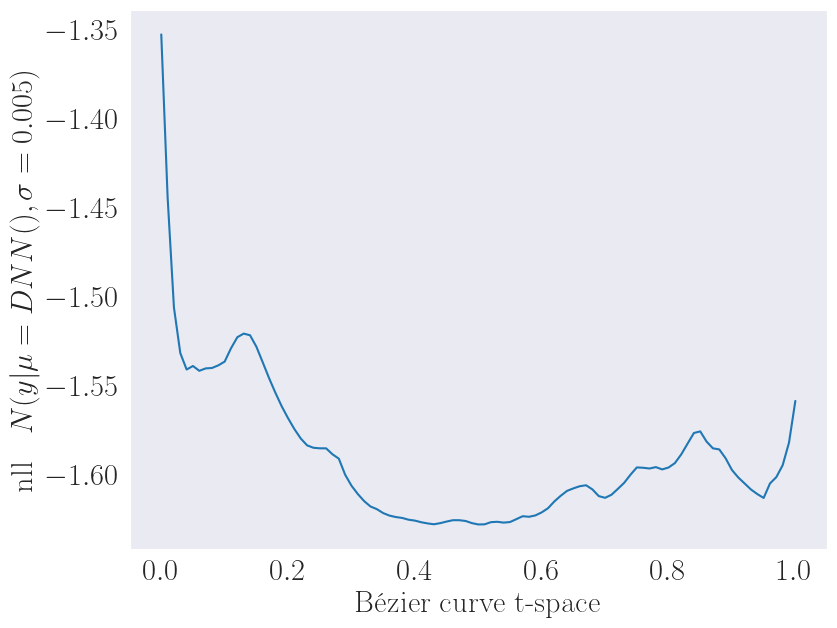

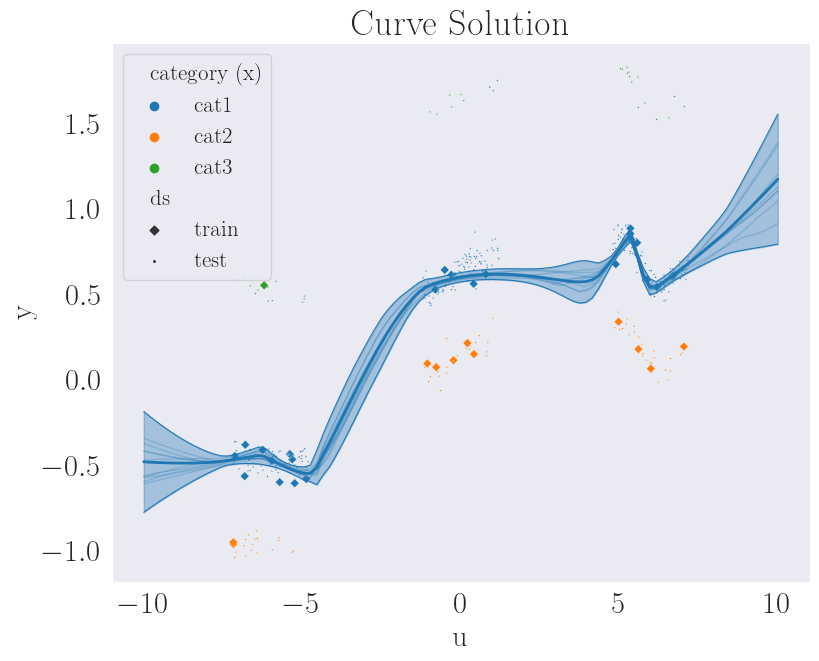

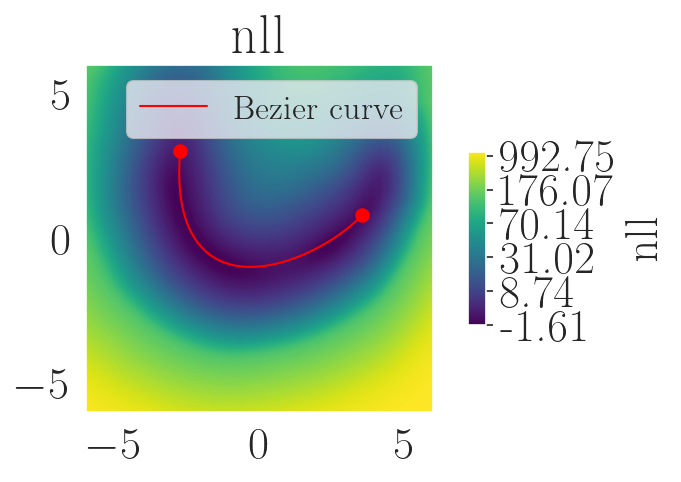

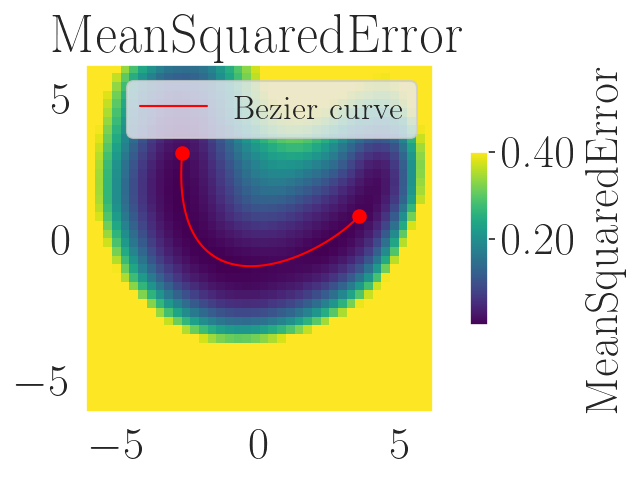

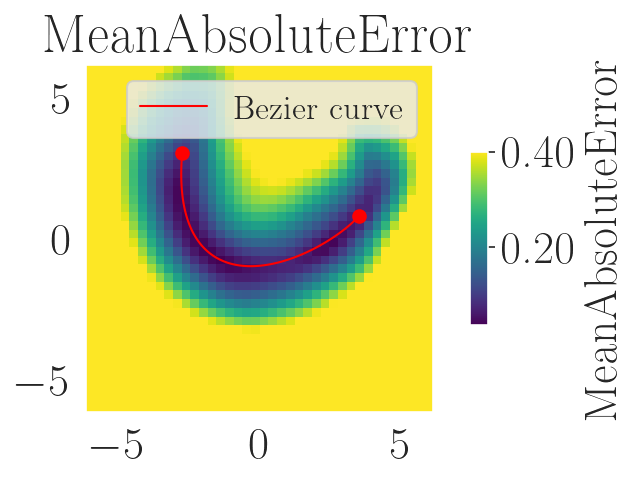

In [9]:
plot_curve_solutions_regression_balckBox(exp_col=exp_col,
                                         best_curve_model=best_curve_model_blackBox,
                                         wandb_logger=wandb_logger)
wandb_curve_exp_id = wandb_logger.experiment.id
wandb.finish()


#### Run HMC for Semi structured model with BlackBox Subspace approximation

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
RegNet
Name: blackBox_curve, ID: j67ckzq7
This run used following artifacts:
Last Acc None
loaded artifact: 
CurveModel
model_state_j67ckzq7:v0


wandb:   1 of 1 files downloaded.  
Global seed set to 10


Instantiate semi subspace model for ess


Warmup [1]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [9]:   0%|          | 0/800 [00:00, ?it/s]

Warmup [10]:   0%|          | 0/800 [00:00, ?it/s]

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_k

test_lppd,470.08932


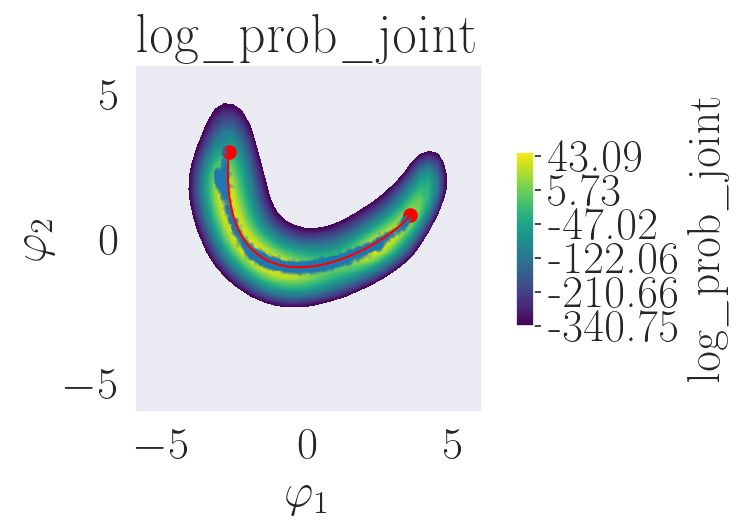

In [10]:
num_chains=10
num_warmup=400
num_samples=400
prior_scale=1.

# to have same sample dimension set num_bends=5
exp_col.num_bends = 5 
wandb_logger = WandbLogger(project=exp_col.wandb_project, log_model=False,
                               name=f'blackBox_Subspace_hmc_from_{wandb_curve_exp_id}',
                               group="RegNetCurve", resume='never')
# log code
wandb_logger.experiment.log_code("./", name=f"project_code_{wandb_logger.experiment.id}",
                                 exclude_fn=exclude_project_code_dirs)
# instantiate basemodel (curve model requires model structure)
model = getModel(RegNet, seed=exp_col.seed, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(device=device)
# reload such that wandb is aware of the dependency
best_curve_model_blackBox, config = load_model(wandb_logger.experiment,
                                      f'ddold/{wandb_logger.experiment.project}/{wandb_curve_exp_id}',
                                      strict=True, file_name=None,
                                      model_cls=type(curve_model_blackBox),
                                      model_start=None, model_end=None, fix_start=False, fix_end=False,
                                      metric_collection=MetricCollection([]),
                                      architecture=CurveArchitectureSemiBlackBox,
                                      architecture_kwargs=dict(base_model=base_model))
mean, cov, S = span_space_from_curve_model(best_curve_model_blackBox.model, num_bends=exp_col.num_bends)
print("Instantiate semi subspace model for ess")

# %% Run HMC on the subspace
torch.set_default_dtype(torch.float32)
pyro.clear_param_store()

pyro_model_blackBox = pyroSemiSubspaceBlackbox(
    mean=mean.to(device=device, dtype=torch.float32),
    cov_factor=cov.to(device=device, dtype=torch.float32),
    sequential_dnn=model.dnn,
    module_structure=model.structure_lin,
    outcome_dist=loss_fn.dist_,
    num_structure=np.sum([p.numel() for p in model.structure_lin.parameters()]))

pyro.set_rng_seed(8)
u_train, x_train, y_train = exp_col.train_dataloader.dataset[:]
nuts_kernel = pyro.infer.NUTS(pyro_model_blackBox,
                              jit_compile=False,
                              adapt_step_size=True,
                              step_size=1e-5,
                              target_accept_prob=0.6,
                              init_strategy=init_to_sample)
mcmc_blackBox = pyro.infer.MCMC(nuts_kernel,
                       num_samples=num_samples,
                       warmup_steps=num_warmup,
                       num_chains=num_chains,
                       mp_context='spawn')
mcmc_blackBox.run(u_train, x_train, y_train)
wandb_logger.experiment.config.update({'num_chains': num_chains,
                                        'num_warmup': num_warmup,
                                        'num_samples': num_samples,
                                        'prior_scale': prior_scale,
                                        'seed': exp_col.seed})
# create arviz inference object
az_post_hmc_blackBox = az.from_pyro(mcmc_blackBox, log_likelihood=False)
az_post_hmc_blackBox = az_post_hmc_blackBox.rename({
    'structure_nn.weight': 'theta',
    'structure_nn.weight_dim_0': 'theta_dim_0',
    'structure_nn.weight_dim_1': 'theta_dim_1'})
# save samples in wandb
az_post_hmc_blackBox.to_netcdf("az_subspace_posterior_blackBox.nc")
art = wandb.Artifact(f"data_{wandb_logger.experiment.id}", type="xarray",
                        description="posterior from blackBox model")
art.add_file("az_subspace_posterior_blackBox.nc")
wandb_logger.experiment.log_artifact(art)
# save pyro model state dict
torch.save(pyro_model_blackBox.state_dict(), "model_state_dict.pt")
art = wandb.Artifact(f"model_state_{wandb_logger.experiment.id}", type="pyroSemiSubspaceBlackbox",
                        description="pyro model state dict")
art.add_file("model_state_dict.pt")
wandb_logger.experiment.log_artifact(art)

# compute lppd
u_test, x_test, y_test = exp_col.test_dataloader.dataset[:]
lppd_test = log_pointwise_predictive_likelihood(pyro_model_blackBox, mcmc_blackBox.get_samples(), u=u_test, x=x_test, y=y_test)
lppd_test = (torch.logsumexp(lppd_test, dim=0) - np.log(lppd_test.shape[0])).sum()
wandb_logger.experiment.summary["test_lppd"] = lppd_test

# compute grid
device = pyro_model_blackBox.device
u_train, x_train, y_train = exp_col.train_dataloader.dataset[:]
x = np.linspace(-6, 6, 40, dtype=np.float32)
y = np.linspace(-6, 6, 40, dtype=np.float32)
xx, yy = np.meshgrid(x, y)
grid = np.vstack([xx.flatten(), yy.flatten()]).T
varphi = torch.hstack([torch.from_numpy(grid).to(device=device), torch.zeros(grid.shape[0],exp_col.num_bends-3, device=device)])
with IndepMessenger("grid", size=grid.shape[0], dim=-2):
    cond_model = pyro.condition(pyro_model_blackBox, data={"varphi": varphi})
    trace = pyro.poutine.trace(cond_model).get_trace(u_train, x_train, y_train)
    trace.compute_log_prob()
log_like = trace.nodes['obs']['log_prob'].sum(1).detach().cpu().numpy()
log_prob_joint = log_like.copy()
log_prob_joint += trace.nodes['varphi']['log_prob'].detach().cpu().numpy()
log_prob_joint = np.nan_to_num(log_prob_joint, nan=np.nan_to_num(-np.inf))
df = pd.DataFrame.from_dict(dict(xx=xx.flatten(),
                                    yy=yy.flatten(),
                                    log_like=log_like,
                                    log_prob_joint=log_prob_joint))
all_curve_params = [np.array([])] * exp_col.num_bends
for n, p in best_curve_model_blackBox.named_parameters():
    control_point_i = n.split('.')[-1]
    if '_' in control_point_i:
        control_point_i = int(control_point_i.split('_')[1])
        all_curve_params[control_point_i] = np.hstack([all_curve_params[control_point_i], p.detach().clone().flatten().numpy()])
all_curve_params = torch.as_tensor(all_curve_params)
p_inv = np.linalg.pinv(cov.cpu().numpy().T)
cp = (all_curve_params.cpu().numpy() - mean.cpu().numpy()) @ p_inv.T  # control points in the subspace
fig = plot_subspace(df, "log_prob_joint", cp[0,:2], cp[1:-1,:2], cp[-1,:2], linear_color=False, interpolate=True, vmin=np.quantile(log_prob_joint, 0.8))
post_varphi = az_post_hmc_blackBox['posterior']['varphi'].to_numpy().reshape(-1, exp_col.num_bends-1)
sns.scatterplot(x=post_varphi[:, 0], y=post_varphi[:, 1], alpha=np.min((0.75, 1000./post_varphi.shape[0])), linewidth=0., s=5)
ax = plt.gca()
ax.get_legend().remove()
ax.set_xlabel(r"$\varphi_1$")
ax.set_ylabel(r"$\varphi_2$")
wandb_logger.experiment.log({'Subspace plot': wandb.Image(plt.gcf())})
wandb.finish()

#### load BlackBox model and samples from wandb

In [5]:
# load samples
exp_col.num_bends = 5
wandb_curve_exp_id = 'j67ckzq7'

art = wandb.Api().artifact('ddold/Semi_Toy_comp_BlackBox_v2/data_61bx8d97:v0')
az_post_hmc_blackBox = az.from_netcdf(art.file())

# load model state
art = wandb.Api().artifact('ddold/Semi_Toy_comp_BlackBox_v2/model_state_61bx8d97:v0')
base_model = getModel(RegNet, seed=exp_col.seed, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(device=device)
num_dnn_params = np.sum([p.numel() for p in base_model.dnn.parameters()])
num_strucutre = np.sum([p.numel() for p in base_model.structure_lin.parameters()])
pyro_model_blackBox = pyroSemiSubspaceBlackbox(
    mean=torch.zeros(num_dnn_params + num_strucutre , device=device, dtype=torch.float32),
    cov_factor=torch.zeros((exp_col.num_bends - 1, num_dnn_params + num_strucutre), device=device, dtype=torch.float32),
    sequential_dnn=base_model.dnn,
    module_structure=base_model.structure_lin,
    outcome_dist=exp_col.nll_fn.dist_,
    num_structure=num_strucutre)
pyro_model_blackBox.load_state_dict(torch.load(art.file()))

# convert arviz samples back for pyro model
# samples = az_post_hmc.posterior.rename({
#         'theta' :'structure_nn.weight',
#         'theta_dim_0' :'structure_nn.weight_dim_0',
#         'theta_dim_1' :'structure_nn.weight_dim_1'})
# samples_pyro = {}
# for name in samples.data_vars:
#     var_samples = samples[name].to_numpy()
#     shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
#     var_samples = var_samples.reshape(shape)
#     samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
pyro_model_blackBox

Global seed set to 10


SemiAdditive
RegNet


pyroSemiSubspaceBlackbox(
  (out_dist): OutcomeDistributionLayer(dist=<class 'pyro.distributions.torch.Normal'>; constrains={'loc': Identity()})
  (sequential_dnn): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (structure_nn): Linear(in_features=2, out_features=1, bias=False)
)

In [8]:
az.summary(az_post_hmc_blackBox)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
varphi[0],-0.624,1.790,-3.191,2.412,0.319,0.293,23.0,23.0,1.36
varphi[1],-0.139,1.098,-1.092,2.181,0.261,0.188,30.0,114.0,1.27
varphi[2],-0.275,0.892,-2.919,0.339,0.276,0.203,27.0,22.0,1.31
varphi[3],0.132,1.081,-0.666,3.195,0.326,0.245,26.0,23.0,1.30


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

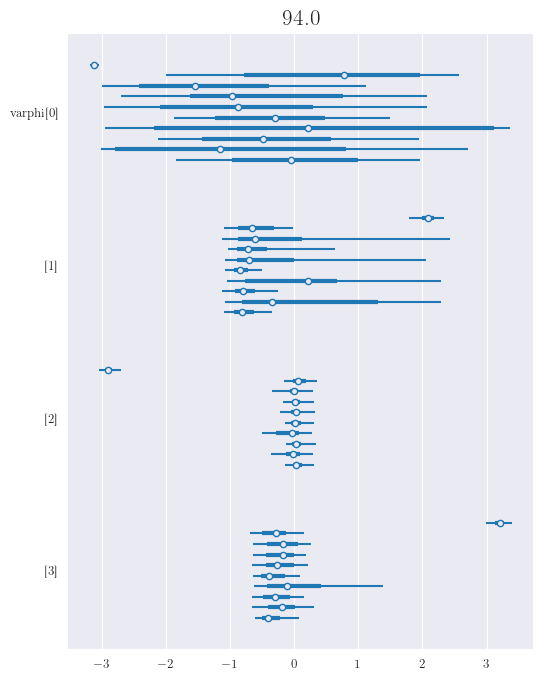

In [9]:
az.plot_forest(az_post_hmc_blackBox)

## Compare predictive performance

Text(0.5, 1.0, 'Subspace posterior predictive')

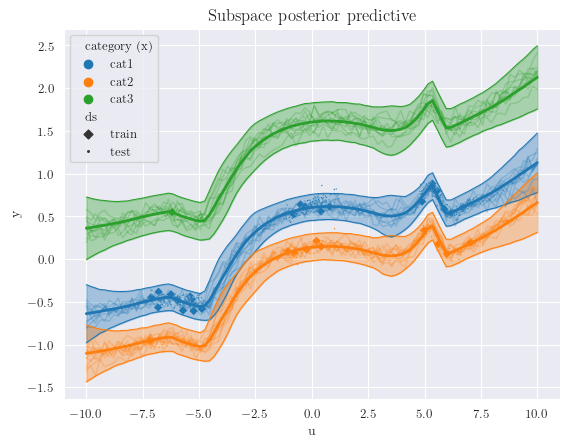

In [10]:
from pyro.infer import Predictive
pyro.clear_param_store()

u_predictive = np.linspace(-10, 10, 100)
u_predictive_t = (features(u_predictive) - exp_col.f_mean) / exp_col.f_std
u_predictive_t = torch.from_numpy(u_predictive_t.astype(np.float32)).to(device=device)
samples = az_post_hmc.posterior.rename({
        'theta' :'structure_nn.weight',
        'theta_dim_0' :'structure_nn.weight_dim_0',
        'theta_dim_1' :'structure_nn.weight_dim_1'})
samples_pyro = {}
for name in samples.data_vars:
    var_samples = samples[name].to_numpy()
    shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
    var_samples = var_samples.reshape(shape)
    samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
posterior_predictive = Predictive(pyro_model, samples_pyro)

meta_zero = torch.zeros_like(u_predictive_t)
post_pred_samples_00 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 1.
post_pred_samples_01 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 0.
meta_zero[:,1] = 1.
post_pred_samples_10 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()

plot_data(exp_col)
def plot_samples(x_axis, preds, ax, color='blue'):
    mu = preds.mean(0)
    sigma = preds.std(0)

    ax.plot(x_axis, mu, "-", lw=2., color=color)
    ax.plot(x_axis, mu - 3 * sigma, "-", lw=0.75, color=color)
    ax.plot(x_axis, mu + 3 * sigma, "-", lw=0.75, color=color)

    np.random.shuffle(preds)
    for traj in preds[:10]:
        ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

    ax.fill_between(x_axis, mu - 3 * sigma, mu + 3 * sigma, alpha=0.35, color=color)

plot_samples(u_predictive, post_pred_samples_00, ax=plt.gca(), color=sns.color_palette()[0])
plot_samples(u_predictive, post_pred_samples_01, ax=plt.gca(), color=sns.color_palette()[1])
plot_samples(u_predictive, post_pred_samples_10, ax=plt.gca(), color=sns.color_palette()[2])
plt.title("Subspace posterior predictive")

Text(0.5, 1.0, 'BlackBox Subspace posterior predictive')

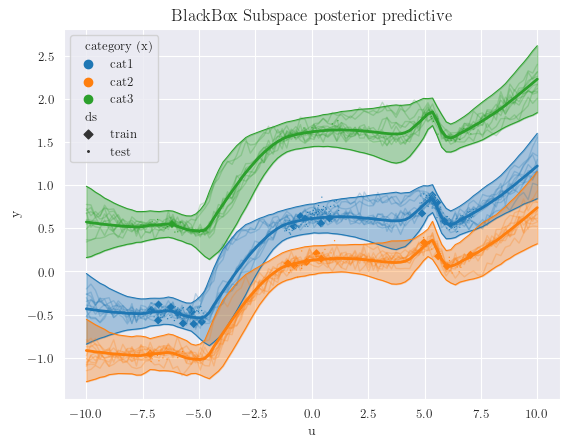

In [11]:
from pyro.infer import Predictive
pyro.clear_param_store()

u_predictive = np.linspace(-10, 10, 100)
u_predictive_t = (features(u_predictive) - exp_col.f_mean) / exp_col.f_std
u_predictive_t = torch.from_numpy(u_predictive_t.astype(np.float32)).to(device=device)
samples = az_post_hmc_blackBox.posterior
samples_pyro = {}
for name in samples.data_vars:
    var_samples = samples[name].to_numpy()
    shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
    var_samples = var_samples.reshape(shape)
    samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
posterior_predictive = Predictive(pyro_model_blackBox, samples_pyro)

meta_zero = torch.zeros_like(u_predictive_t)
post_pred_samples_00_b = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 1.
post_pred_samples_01_b = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 0.
meta_zero[:,1] = 1.
post_pred_samples_10_b = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()

plot_data(exp_col)
def plot_samples(x_axis, preds, ax, color='blue'):
    mu = preds.mean(0)
    sigma = preds.std(0)

    ax.plot(x_axis, mu, "-", lw=2., color=color)
    ax.plot(x_axis, mu - 3 * sigma, "-", lw=0.75, color=color)
    ax.plot(x_axis, mu + 3 * sigma, "-", lw=0.75, color=color)

    np.random.shuffle(preds)
    for traj in preds[:10]:
        ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

    ax.fill_between(x_axis, mu - 3 * sigma, mu + 3 * sigma, alpha=0.35, color=color)

plot_samples(u_predictive, post_pred_samples_00_b, ax=plt.gca(), color=sns.color_palette()[0])
plot_samples(u_predictive, post_pred_samples_01_b, ax=plt.gca(), color=sns.color_palette()[1])
plot_samples(u_predictive, post_pred_samples_10_b, ax=plt.gca(), color=sns.color_palette()[2])
plt.title("BlackBox Subspace posterior predictive")

Text(0.5, 1.0, 'Posterior predictive comparison')

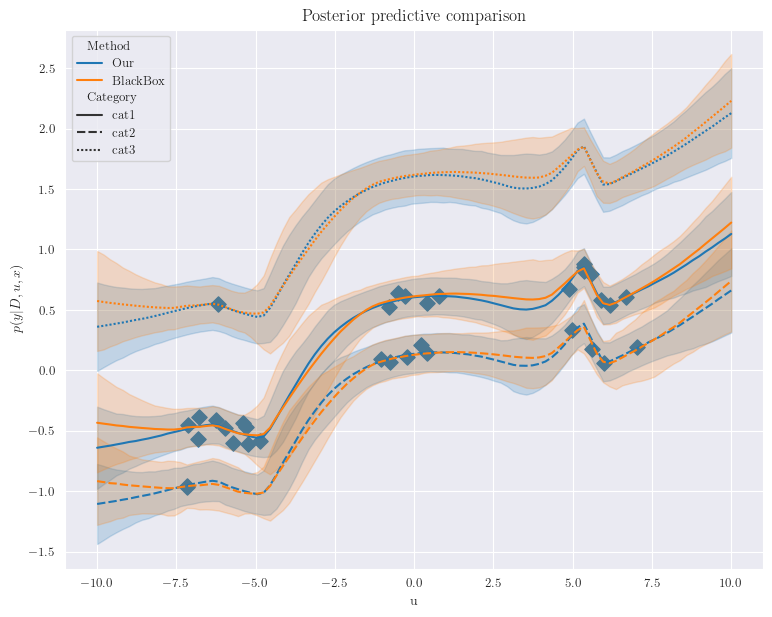

In [12]:
df_postpred = pd.DataFrame(post_pred_samples_00.T)
df_postpred['u'] = u_predictive
df_postpred['Category'] = 'cat1'
temp = pd.DataFrame(post_pred_samples_01.T)
temp['u'] = u_predictive
temp['Category'] = 'cat2'
df_postpred = pd.concat([df_postpred, temp])
temp = pd.DataFrame(post_pred_samples_10.T)
temp['u'] = u_predictive
temp['Category'] = 'cat3'
df_postpred = pd.concat([df_postpred, temp])

df_postpred_b = pd.DataFrame(post_pred_samples_00_b.T)
df_postpred_b['u'] = u_predictive
df_postpred_b['Category'] = 'cat1'
temp = pd.DataFrame(post_pred_samples_01_b.T)
temp['u'] = u_predictive
temp['Category'] = 'cat2'
df_postpred_b = pd.concat([df_postpred_b, temp])
temp = pd.DataFrame(post_pred_samples_10_b.T)
temp['u'] = u_predictive
temp['Category'] = 'cat3'
df_postpred_b = pd.concat([df_postpred_b, temp])

df_postpred = pd.concat([df_postpred, df_postpred_b], keys=['Our', 'BlackBox'], names=['Method', 'index']).reset_index()
df_postpred = df_postpred.melt(id_vars=['Method', 'u', 'index', 'Category'], var_name='Sample', value_name='y')

filepath = "dataframe_posterior_predictive_SemiSub_vs_BlacBox.pkl"
df_postpred.to_pickle(filepath)
# art.add_file(filepath)
# run.log_artifact(art)

fig = plt.figure(figsize=(9., 7.))
plt.scatter(exp_col.df[('data','x')], exp_col.df[('data','y')], marker='D', s=(60))
# plot_data(exp_col)
sns.lineplot(data=df_postpred, x='u', y='y', style='Category', hue='Method', errorbar=('sd', 3))
plt.ylabel(r"$p(y|D, u, x)$")
plt.title("Posterior predictive comparison")
# run.log({'Posterior predictive comparison BlackBox': wandb.Image(plt.gcf())})

## Compare structural posterior

In [6]:
art = wandb.Api().artifact('ddold/semi_regression_v2/data_wuwhc7kr:v0')
az_post_hmc_fullSpace = az.from_netcdf(art.file())
az_post_hmc_fullSpace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [7]:
# art = wandb.Api().artifact('ddold/Semi_Toy_comp_BlackBox_v2/data_l0knozu7:v0')
# az_post_hmc_blackBox= az.from_netcdf(art.file())

# art = wandb.Api().artifact('ddold/Semi_Toy_comp_BlackBox_v2/data_mapifcld:v0')
# az_post_hmc= az.from_netcdf(art.file())

wandb: Currently logged in as: ddold. Use `wandb login --relogin` to force relogin


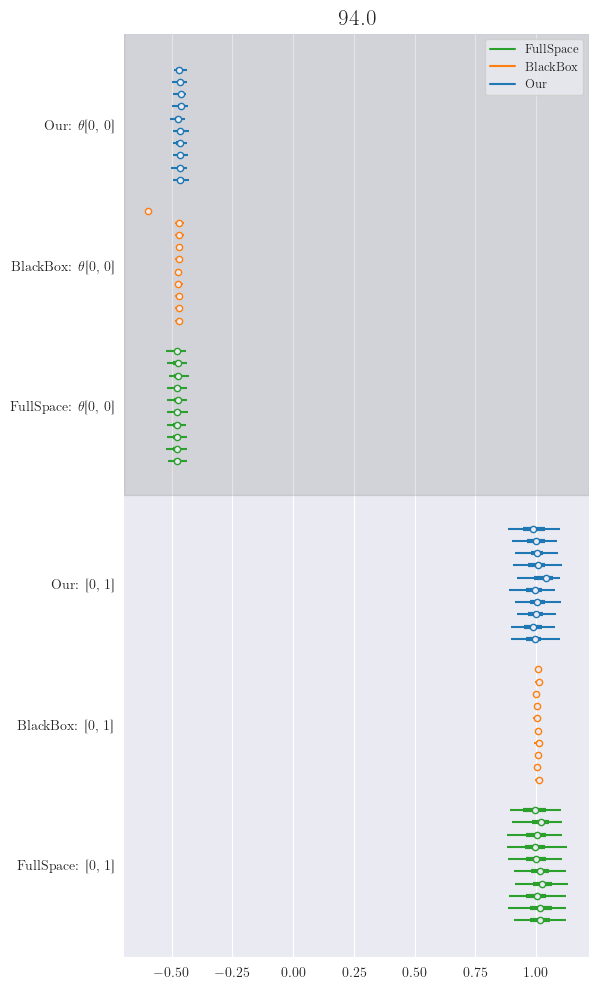

In [8]:
run = wandb.init(project=exp_col.wandb_project, entity='ddold', name=f'compare_{wandb_exp_id}_vs_{wandb_curve_exp_id}')
varphi_samples = az.extract(az_post_hmc_blackBox, var_names='varphi', combined=False).to_numpy()
phi_samples = varphi_samples @ pyro_model_blackBox.cov.detach().cpu().numpy() +  pyro_model_blackBox.mean.detach().cpu().numpy()
phi_samples = phi_samples[...,np.newaxis,:]
az_post_hmc_blackBox_project = az.from_dict(posterior={'theta':phi_samples[...,-2:]})
labeller = az.labels.MapLabeller(var_name_map={"theta": r"$\theta$", "varphi": r"$\varphi$"})


az.plot_forest([az_post_hmc, az_post_hmc_blackBox_project, az_post_hmc_fullSpace], var_names="theta", model_names=['Our', 'BlackBox', 'FullSpace'], labeller=labeller)
run.log({"Forest plot": wandb.Image(plt.gcf())})

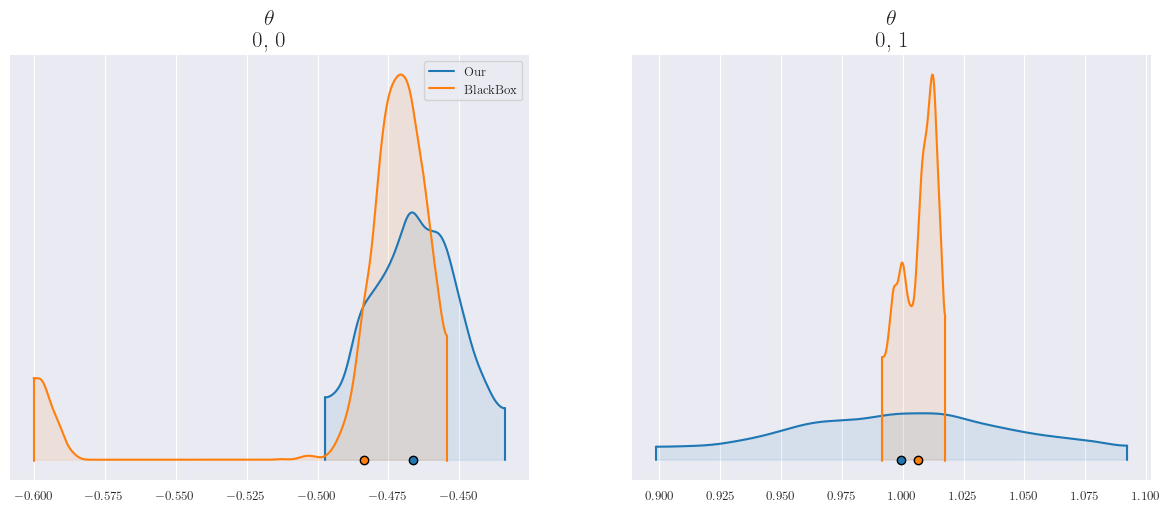

In [16]:
az.plot_density([az_post_hmc, az_post_hmc_blackBox_project], var_names="theta", data_labels=['Our', 'BlackBox'], shade=0.1, labeller=labeller)
run.log({"density plot": wandb.Image(plt.gcf())})

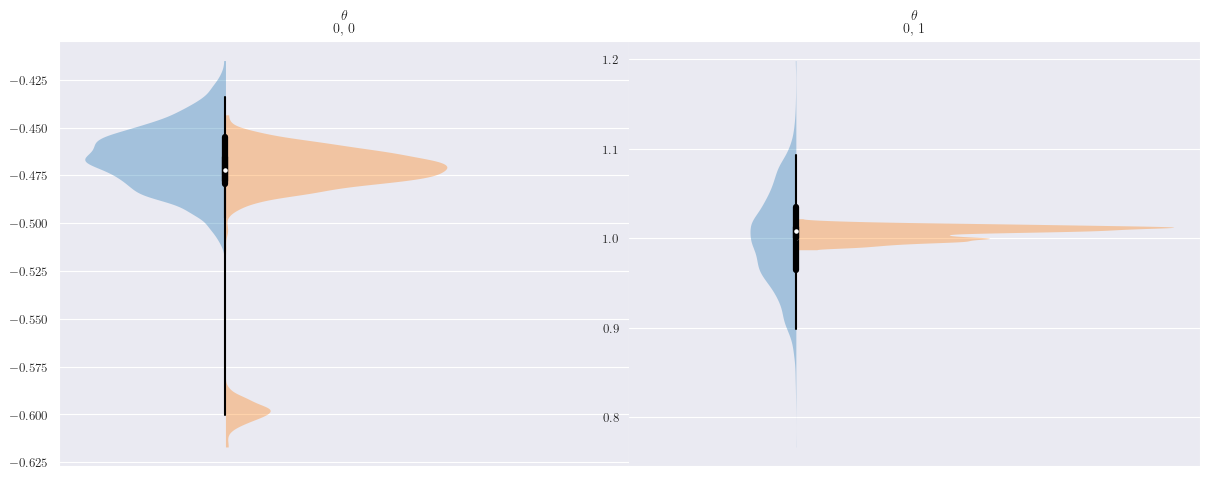

<Figure size 640x480 with 0 Axes>

In [17]:
axes = az.plot_violin(az_post_hmc, var_names="theta", side="left", show=False, sharey=False, labeller=labeller)
az.plot_violin(az_post_hmc_blackBox_project, var_names="theta", side="right", ax=axes, show=True, sharey=False, labeller=labeller)
plt.tight_layout()
run.log({"Violin plot": wandb.Image(plt.gcf())})

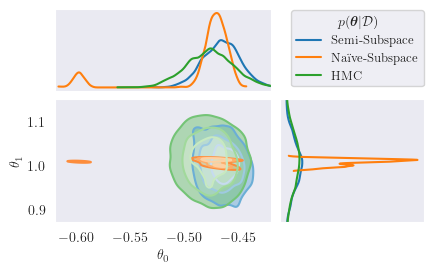

In [10]:
gs_kw = dict(height_ratios=[figsize[0]*0.4, figsize[0]*0.6], width_ratios=[figsize[1]*0.6, figsize[1]*0.4])
fig6, f6_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(figsize[0]*1.3, figsize[1]*1.3),
        gridspec_kw=gs_kw)
axes = az.plot_pair(az_post_hmc, 
    var_names="theta", 
    labeller=labeller, 
    marginals=True, 
#    figsize=figsize,
    kind='kde', 
    ax=f6_axes,
    marginal_kwargs={'color':sns.color_palette()[0]}, 
    kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75],
                    contour_kwargs={"colors":sns.color_palette('tab20c')[:4]},
                    contourf_kwargs={"alpha":0.5, 'colors':sns.color_palette('tab20c')[:4]}))
axes = az.plot_pair(az_post_hmc_blackBox_project, 
             var_names="theta", 
             labeller=labeller, 
             marginals=True, 
             kind='kde', 
             ax=axes, 
             marginal_kwargs={'color':sns.color_palette()[1]}, 
             kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75], 
                             contour_kwargs={"colors":sns.color_palette('tab20c')[4:8]},
                             contourf_kwargs={"alpha":0.5, 'colors':(sns.color_palette('tab20c')[4:8])}))
axes = az.plot_pair(az_post_hmc_fullSpace, 
             var_names="theta", 
             labeller=labeller, 
             marginals=True, 
             kind='kde', 
             ax=axes, 
             marginal_kwargs={'color':sns.color_palette()[2]}, 
             kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75], 
                             contour_kwargs={"colors":sns.color_palette('tab20c')[8:12]},
                             contourf_kwargs={"alpha":0.5, 'colors':(sns.color_palette('tab20c')[8:12])}))

import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color=sns.color_palette()[0], label='Semi-Subspace')
orange_line = mlines.Line2D([], [], color=sns.color_palette()[1], label=r'Na\"ive-Subspace')
green_line = mlines.Line2D([], [], color=sns.color_palette()[2], label='HMC')
fig6.legend(handles=[blue_line, orange_line, green_line], loc='outside upper right', bbox_to_anchor=(0.99, .98,), bbox_transform=fig6.transFigure, mode=None, borderaxespad=0., title=r'$p(\boldsymbol{\theta}|\mathcal{D})$')
run.log({"Posterior KDE plot": wandb.Image(plt.gcf())})
axes[1][0].set_xlabel(r'$\theta_0$')
axes[1][0].set_ylim(0.87,1.15)
axes[1][0].set_xlim(-0.62,-0.42)
axes[1][1].set_ylim(0.87,1.15)
axes[0][0].set_xlim(-0.62,-0.42)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])
axes[1][0].set_ylabel(r'$\theta_1$')
plt.savefig("figures2/vanilla_comp_post.pdf", bbox_inches='tight')
# plt.tight_layout()

In [83]:
wandb.finish()

In [183]:
# load pyro model
torch.save(pyro_model_blackBox.state_dict(), "test_pyro_save.pt")
# instantiate basemodel (curve model requires model structure)
model = getModel(RegNet, seed=exp_col.seed, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(device=device)
pyro_model_blackBox_load = pyroSemiSubspaceBlackbox(
    mean=torch.zeros(339, device=device, dtype=torch.float32),
    cov_factor=torch.zeros((4, 339), device=device, dtype=torch.float32),
    sequential_dnn=model.dnn,
    module_structure=model.structure_lin,
    outcome_dist=loss_fn.dist_,
    num_structure=np.sum([p.numel() for p in model.structure_lin.parameters()]))
pyro_model_blackBox_load.load_state_dict(torch.load("test_pyro_save.pt"))
pyro_model_blackBox_load.cov

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


SemiAdditive
RegNet


Parameter containing:
tensor([[-9.2165e-02, -9.4212e-02,  2.4126e-02,  ...,  1.0166e-02,
         -1.8202e-04,  4.4362e-03],
        [-2.6996e-02,  3.3346e-02, -1.2302e-01,  ...,  2.2953e-02,
         -1.8658e-03, -2.3329e-03],
        [-1.9814e-01, -8.7637e-02,  2.0742e-01,  ..., -1.5727e-03,
         -1.7081e-03, -7.0922e-02],
        [ 1.7464e-02,  6.4420e-03, -1.0242e-01,  ..., -6.0485e-02,
          2.3332e-03,  3.1169e-02]], device='cuda:0', requires_grad=True)